In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# TRAFFIC_DATA_SIZE = 2845343

In [3]:
FIG_PREFIX = 'traffic'

In [4]:
root_dir = '../result/traffic_result_new2'
id_cols = ['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys']

In [29]:
def build_stats_filename(row):
    name = row['name']
    if 'parallel' in name:
        name = name.split('-')[0]
    fields = [name, str(int(row['num_threads'])), str(int(row['gram_size'])), str(row['selectivity']), 'stats.csv']
    return '_'.join(fields)

In [30]:
def get_stats_df(row):
    fname = build_stats_filename(row)
    return pd.read_csv(os.path.join(root_dir, fname), sep='\t')

In [31]:
summary_path = os.path.join(root_dir, 'summary.csv')
summary_df = pd.read_csv(summary_path)

In [32]:
summary_df.ffill(inplace=True)
summary_df['overall_match_time'] = summary_df['compile_time'] + summary_df['match_time']
summary_df.rename(columns={'overall_time': 'overall_index_time', '    name': 'name'}, inplace=True)
summary_df['overall_time'] = summary_df['overall_index_time'] + summary_df['overall_match_time']

In [33]:
# code for getting end-to-end trimmed mean
res = summary_df.sort_values('overall_time')
res = res.drop(res.groupby(by=id_cols).tail(1).index)
res = res.drop(res.groupby(by=id_cols).head(1).index)

In [34]:
res_df = res.groupby(by=id_cols, as_index=False).mean(numeric_only=True).apply(lambda x: x)

In [35]:
def add_num_after_filter(df):
    new_cols = {
        'num_after_filter': [],
        'per_query_num_after_filter': [],
        'match_count': []
    }
    
    for _, row in df.iterrows():
        detail_df = get_stats_df(row)
        new_cols['num_after_filter'].append(detail_df['num_after_filter'].sum())
        new_cols['per_query_num_after_filter'].append(detail_df['num_after_filter'].mean())
        new_cols['match_count'].append(detail_df['count'].sum())
        # if detail_df['count'].sum() != 368166:
        # print(build_stats_filename(row))
        # print(detail_df)
    return df.assign(**new_cols)

In [36]:
res_df = add_num_after_filter(res_df)
res_df.describe()

,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count
count,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,4.480000e+02,448.000000,448.000000,448.000000,448.000000,4.480000e+02,4.480000e+02,448.0
mean,4.671875,4.776786,0.164732,11341.129464,288.517153,30.688828,319.206080,7.137685e+08,0.000895,2.401787,2.402682,321.608762,4.185349e+06,1.046337e+06,368166.0
std,3.319243,3.383629,0.188257,14286.846556,1890.787547,31.782180,1887.680952,3.783357e+08,0.001181,0.931577,0.931890,1887.596821,2.866151e+06,7.165378e+05,0.0
min,1.000000,-1.000000,0.010000,2.000000,17.442700,0.000080,21.995500,2.240000e+02,0.000080,1.102215,1.102558,23.733704,4.539400e+05,1.134850e+05,368166.0
25%,1.000000,2.000000,0.030000,1984.000000,29.389100,8.423047,44.571575,4.988982e+08,0.000171,1.910540,1.910947,46.621893,2.993200e+06,7.483000e+05,368166.0
50%,4.000000,4.000000,0.100000,6443.500000,50.380200,19.693750,75.759750,8.796338e+08,0.000507,2.009642,2.010481,77.777911,2.993334e+06,7.483335e+05,368166.0
75%,8.000000,8.000000,0.200000,14208.000000,87.829850,42.744325,146.694250,1.003990e+09,0.001100,2.938546,2.939928,149.381817,5.734148e+06,1.433537e+06,368166.0
max,10.000000,10.000000,0.700000,66147.000000,36179.800000,171.487000,36179.900000,1.176186e+09,0.010720,4.946878,4.947054,36181.232290,1.138137e+07,2.845343e+06,368166.0


In [37]:
exam_df = res_df[res_df['num_threads'] == 10]

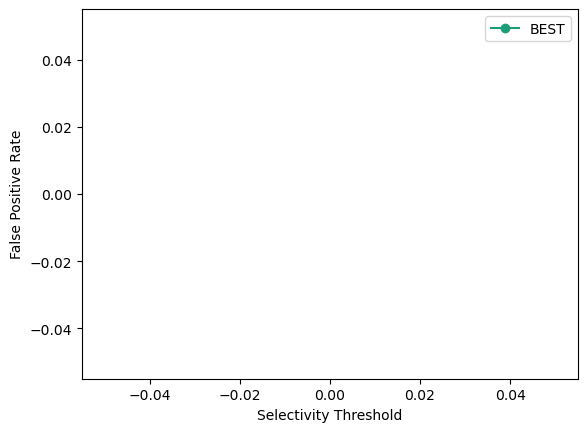

ValueError: not enough values to unpack (expected 2, got 0)

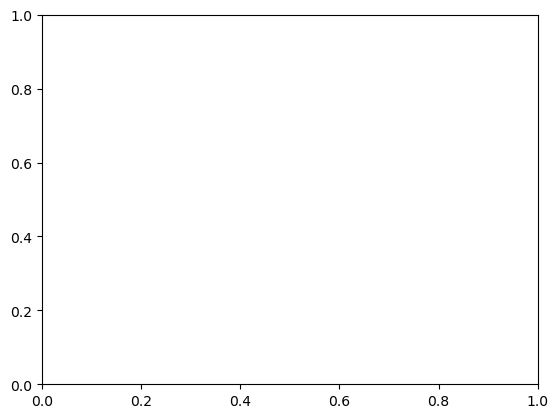

In [ ]:
# gram size vs accuracy
temp_g = res_df[res_df['num_threads'] == 1]
colors = ['#1b9e77','#d95f02','#7570b3']
# for i, name in enumerate(['BEST', 'FREE']):
#     ax = plt.subplot()
#     temp = temp_g[temp_g['name'].str.contains(name)]
#     x = temp['selectivity']
#     y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
#     x, y = zip(*sorted(zip(x, y)))
#     print(temp)
#     ax.plot(x, y, label=name, c=colors[i]) 
#     plt.xlabel('Max Gram Size')
#     plt.ylabel('False Positive Rate')
#     plt.legend()
#     plt.savefig(f'figs/{FIG_PREFIX}_sel_false_positive.pdf', bbox_inches='tight')

#     plt.show()

# BEST
ax = plt.subplot()
temp = temp_g[temp_g['name'].str.contains('BEST')]
x = temp['selectivity']
y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
# x, y = zip(*sorted(zip(x, y)))
# print(temp)
ax.plot(x, y, marker='o', label='BEST', c=colors[0]) 
plt.xlabel('Selectivity Threshold')
plt.ylabel('False Positive Rate')
plt.legend()
plt.savefig(f'figs/{FIG_PREFIX}_best_sel_vs_fp.pdf', bbox_inches='tight')
plt.show()

# FREE
ax = plt.subplot()
temp = temp_g[(temp_g['name'] == ('FREE')) & (temp_g['gram_size'] == 10)]
x = temp['selectivity']
y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
x, y = zip(*sorted(zip(x, y)))
ax.plot(x, y, marker='o', label='FREE', c=colors[1]) 

temp = temp_g[(temp_g['name'].str.contains('FREE-')) & (temp_g['gram_size'] == 10)]
x = temp['selectivity']
y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
x, y = zip(*sorted(zip(x, y)))
ax.plot(x, y, marker='o', label='FREE-presuf', c=colors[2]) 

plt.xlabel('Selectivity Threshold')
plt.ylabel('False Positive Rate')
plt.legend()
plt.savefig(f'figs/{FIG_PREFIX}_free_sel_vs_fp.pdf', bbox_inches='tight')
plt.show()

In [15]:
best_df = res_df[res_df['name'].str.contains('BEST')]

In [16]:
free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]

In [17]:
# free with c = 0.1, plot false positive rate against gramsize 
# free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]
temp_free = free_df[free_df['selectivity'] == 0.1]

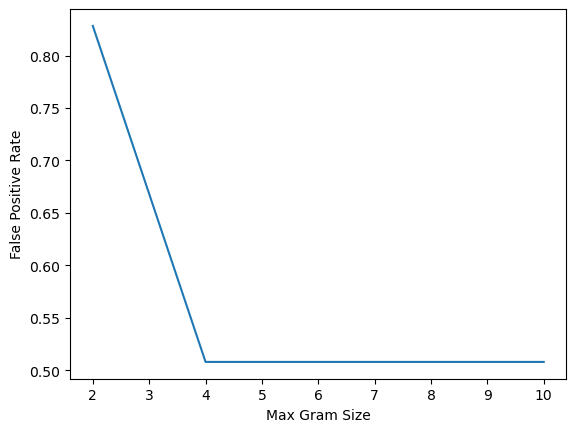

In [18]:
# gram size vs accuracy
temp = temp_free[temp_free['num_threads'] == 1]
ax = plt.subplot()
x = temp['gram_size']
y = (temp['per_query_num_after_filter'] - temp['match_count']) / temp['per_query_num_after_filter']
ax.plot(x, y) 
plt.xlabel('Max Gram Size')
plt.ylabel('False Positive Rate')
plt.show()

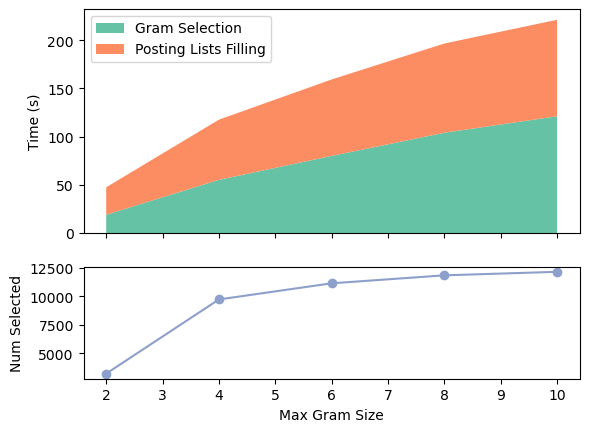

In [19]:
# gram size vs index size; gram size vs index build time
fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

colors = ['#66c2a5','#fc8d62','#8da0cb']

temp = temp_free[temp_free['num_threads'] == 1]
x = temp['gram_size']
y_1 = temp['overall_index_time']
y_1_1 = temp['selection_time']
y_1_2 = temp['build_time']

y_2 = temp['num_keys']

axs[0].stackplot(x, y_1_1, y_1_2, labels=[
    'Gram Selection', 'Posting Lists Filling' #, 'Overall Index Construction'
],
    colors=colors[:-1])

# axs[0].plot(x, y_1, label='Overall Index Construction') 
# axs[0].plot(x, y_1_1, label='Gram Selection') 
# axs[0].plot(x, y_1_2, label='Posting Lists Filling') 
axs[0].set_ylabel('Time (s)')
axs[0].legend(loc='upper left')

axs[1].plot(x, y_2, marker='o', c=colors[-1])
axs[1].set_ylabel('Num Selected')

plt.xlabel('Max Gram Size')
plt.savefig(f'figs/{FIG_PREFIX}free_n_vs_index-time_num-keys.pdf', bbox_inches='tight')

plt.show()

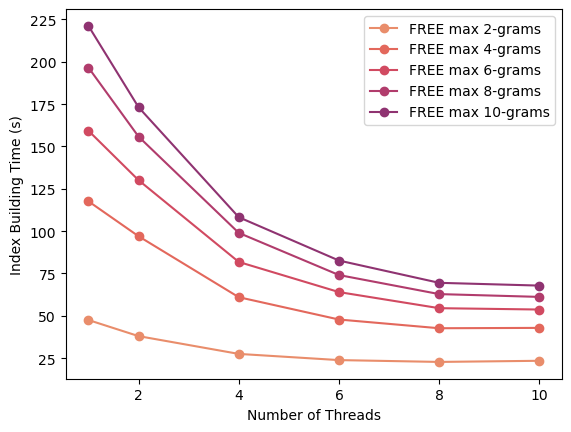

In [20]:
# thread vs. build time; label by gram size
ax = plt.subplot()
seq_colors = sns.color_palette("flare")#, as_cmap=True)
for i, gram_size in enumerate(temp_free['gram_size'].unique()):
    temp = temp_free[temp_free['gram_size'] == gram_size]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='FREE max {}-grams'.format(int(gram_size)), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}free_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()

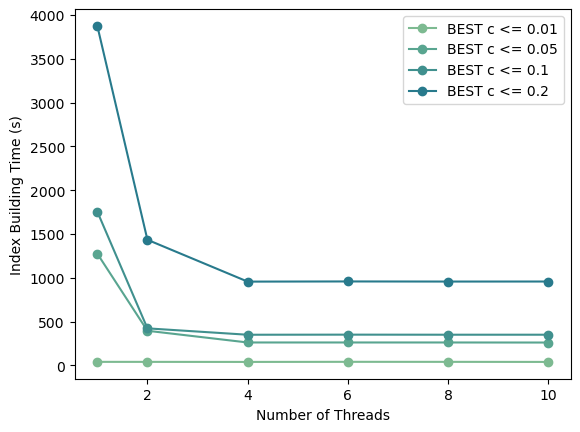

In [21]:
# thread vs. build time; label by gram size
# temp_best = best_df[best_df['selectivity'] == 0.05]
# print(temp_best)
ax = plt.subplot()
seq_colors = sns.color_palette("crest")#, n_colors=11)#, as_cmap=True)
# for i, sel in enumerate(best_df['selectivity'].unique()):
for i, sel in enumerate([0.01, 0.05,0.1, 0.2]):
    temp = best_df[best_df['selectivity'] == sel]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='BEST c <= {}'.format(sel), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}_best_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()